In [2]:
import tensorflow as tf
from tensorflow import keras

- 메모리에 들어갈 수 없을 정도의 데이터도 효율적으로 로드하고 전처리할 수 있음
    - 객체를 만들고 데이터를 읽어 올 위치와 변환 방법만 지정해주면, 멀티스레딩, 큐, 배치, 프리페치와 같은 사항을 처리해줌

- tf.Transform : tf 변환
    - 훈련 전에 전체 훈련세트에 대해 실행하는 전처리함수를 작성할 수 있으며, 그 다음 텐서플로 함수로 변환하고, 배포한 다음 훈련된 모델과 협업하여 새로운 샘플에 대해 동적으로 전처리 수행 가능
    - 일종의 파이프라인 역할을 수행하게 할 수 있음
- TFDS : tf데이터 셋
    - 각종 데이터셋을 다운로드할 수 있는 편리한 함수를 제공함

# 13.1. 데이터 API
- 가장 중심에는 dataset개념이 있음
- 연속된 데이터 샘플을 나타내며, 일반적으로 디스크에서 데이터를 점진적으로 읽는 데이터셋을 사용함
    - 그래서 아주 큰 데이터셋을 효율적으로 처리할 수 있음

In [3]:
# 작은 데이터에[서 테스트
X = tf.range(10)
X

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

- Dataset모듈의 from_tensor_slices()함수는 텐서를 받아서 첫 차원을(위 케이스에서는 shape = (10, )의 10) 따라 X의 각 원소가 아이템으로 표현되는 tf.data.Dataset객체를 반환함
    - 즉 지금 이 데이터셋의 경우 텐서 0 ~ 9에 해당하는 10개의 아이템을 갖는데, 이는 tf.data.Dataset.range(10)과 동일함

In [5]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


### 13.1.1. 연쇄 변환
- 위에서 처럼 데이터셋이 준비되면, 변환 메서드를 호출해서 여러 종류의 변환을 수행할 수 있음
    - 각 메서드는 새로운 데이터셋을 반환함
    - 따라서 변환 메서드를 연결할 수 있음

In [6]:
dataset = dataset.repeat(3).batch(7)
    # 데이터셋을 세번 반복하는 변환 메서드 적용
    # 이 변환은 메모리에서 데이터를 복사하는 것이 아님
    # 그 다음 바로 연쇄변환을 통해 batch_size = 7로 배치작업 수행
    # batch()에 인자로 drop_remainder = True로 호출하면 길이가 모자란 배치를 버리게 됨
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


- 데이터셋 메서드는 데이터셋을 바꾸지 않고 새로운 데이터셋을 만듬. 즉 inplace = False라고 생각하면 됨

- map() 메서드를 통해 아이템을 변환할 수도 있음
    - df.apply(lambda) 식과 비슷

In [7]:
dataset = dataset.map(lambda x : x * 2)

In [8]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


- 이 map은 어떠한 전처리 작업에도 적용할 수 있음
- 간혹 여러 스레드로 나눠처리하는 것이 좋을 떄도 있는데, 이때는 num_parallel_calls 인자를 지정하면 오케이임

- map은 각 아이템에 변환을 적용하지만, apply메서드는 데이터셋 전체에 변환을 적용함
    - 다음 코드는 데이터셋에 unbatch()함수를 적용하는 것
- pandas의 apply는 map과 동일함

In [9]:
dataset = dataset.apply(tf.data.experimental.unbatch())
for item in dataset:
    print(item)

Instructions for updating:
Use `tf.data.Dataset.unbatch()`.
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(12, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(16, shape=(), dtype=int32)
tf.Tensor(18, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=

- filter()와 lambda를 같이 쓰면 필터링도 가능

In [10]:
dataset = dataset.filter(lambda x : x < 10)
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)


- 몇몇 아이템만 골라서 보고싶을 경우 take()메서드 활용

In [11]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)


### 13.1.2. 데이터 셔플링
- shuffle메서드로 샘플을 섞으면 훈련 세트에 있는 샘플을 독립적이고 동일한 분포로 만들 수 있음
- 이 메서드는 원본 데이터셋의 첫 아이템을 buffer_size만큼 추출해서 버퍼에 채움
    - 그 다음 새로운 아이템이 요청되면 이 버퍼에서 랜덤하게 하나를 꺼내 반환
    - 그리고 원본 데이터에서 새로운 아이템을 추출하여 비워진 버퍼를 채움
    - 이 과정을 반복하여 원본 데이터셋의 모든 아이템이 사용될 때까지 반복
- 버퍼 크기는 충분히 크게 하는 것이 중요하지만, 동시에 이 사이즈가 메모리 크기를 넘지는 않아야함
    - 그리고 데이터셋보다 굳이 클 필요는 없음

In [12]:
# 0~9까지 세번 반복된 데이터셋을 만들고 버퍼 크기 5와 랜덤시드 42를 사용하여 셔플링 후 배치크기 7로 나누는 작업
dataset = tf.data.Dataset.range(10).repeat(3).shuffle(buffer_size = 5, seed = 42).batch(7)
# 지금은 일부러 연쇄변환을 적용한거고, 너무 길어지면 따로 떼서 보자
for item in dataset:
    print(item)

tf.Tensor([0 2 3 6 7 9 4], shape=(7,), dtype=int64)
tf.Tensor([5 0 1 1 8 6 5], shape=(7,), dtype=int64)
tf.Tensor([4 8 7 1 2 3 0], shape=(7,), dtype=int64)
tf.Tensor([5 4 2 7 8 9 9], shape=(7,), dtype=int64)
tf.Tensor([3 6], shape=(2,), dtype=int64)


- 메모리 용량보다 큰 대규모 데이터셋은 버퍼가 데이터셋에 비해 작아 간단한 셔플링 버퍼 방식으로는 충분하지 않음
    - 이를 해결하기 위해서는 원본 데이터 자체를 섞어버리는 방법이 있음
    - 이렇게 하면 셔플링 효과를 크게 향상시킬 수 있음
- 그리고 원본 데이터가 셔플링 되어있더라도 에포크마다 한 번 더 섞어 모델에서 편향을 최대한 제거함
- 추가로 샘플을 더 섞기 위해서 쓰는 방법은 원본 데이터를 여러 파일로 나눈 다음 훈련 중에 무작위로 몇 개의 파일을 선택하여 읽어들이고 그 위에 셔플링 버퍼를 추가하는 방법을 사용함

##### 여러 파일에서 한 줄 씩 번갈아가며 일기
- 훈련, 검증, 테스트 세트로 데이터를 나눴다고 가정하고, 각 세트를 여러개로 쪼갬
- 그리고 Dataset클래스의 list_files함수를 이용하면 파일 경로를 섞은 데이터셋을 반환
    - 경로는 os.listdir()를 썼을 떄 처럼, 파일명의 리스트로 지정되야함
    - 예를 들면 다음과 같이 쓸 수 있음

In [13]:
# train_filepaths = os.listdir("datasets/housing/my_train_*.csv")
# filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed = 42)

- 그리고 만들어진 객체의 interleave()메서드를 호출하면 한 번에 다섯 개의 파일을 한 줄씩 번갈아가며 읽게됨

In [14]:
# n_readers = 5
# dataset = filepath_dataset.interleave(
#     lambda filepath : tf.data.TextLineDataset(filepath).skip(1),
#     cycle_length = n_readers)

- interleave메서드를 사용하면 filepath_dataset에 있는 파일 경로에서 데이터를 읽는 데이터셋을 만듬
    - 그리고 이 메서드에 전달한 함수(여기서는 람다를 전달함)를 각 파일에 대해 호출하여 새로운 데이터셋을 만들게 됨
- 기본적으로 interleave메서드는 병렬처리를 하지 않고 각 파일에서 한 번에 한 줄씩 읽어옴
    - 만약 병렬처리를 하고 싶다면 num_parallel_calls 인자에 스레드 개수를 지정할 수 있음
    - *map 메서드도 이 인자를 지원함*
    - 이 매개변수를 tf.data.experimental.AUTOTUNE으로 지정하면 텐서플로가 알아서 스레드 개수를 선택할 수 있음

In [15]:
# for line in dataset.take(5):
#     print(line.numpy())

### 13.1.3. 데이터 전처리
- 위에서 한 줄씩 읽어들이니까, 한 줄씩 전처리를 수행할 수 있는 함수를 만들어 이어줄 수 있음

In [16]:
# X_mean, X_std = [...]
# n_inputs = 8

# def preprocess(line):
#     defs = [0.] * n_inputsx + [tf.constant([], dtype = tf.float32)]
#     fileds = tf.io.decode_csv(line, record_defaults = defs)
#     x = tf.stack(fields[:-1])
#     y = tf.stack(fields[-1:])
#     return (x - X_mean) / X_std, y

### 13.1.4. 데이터 적재와 전처리 연결
- 재사용 가능한 코드를 만들기 위해 위 과정들을 하나의 헬퍼 함수로 만들 수 있음
- *이 함수는 캘리포니아 주택 데이터셋을 처리하는 함수라고 생각
- 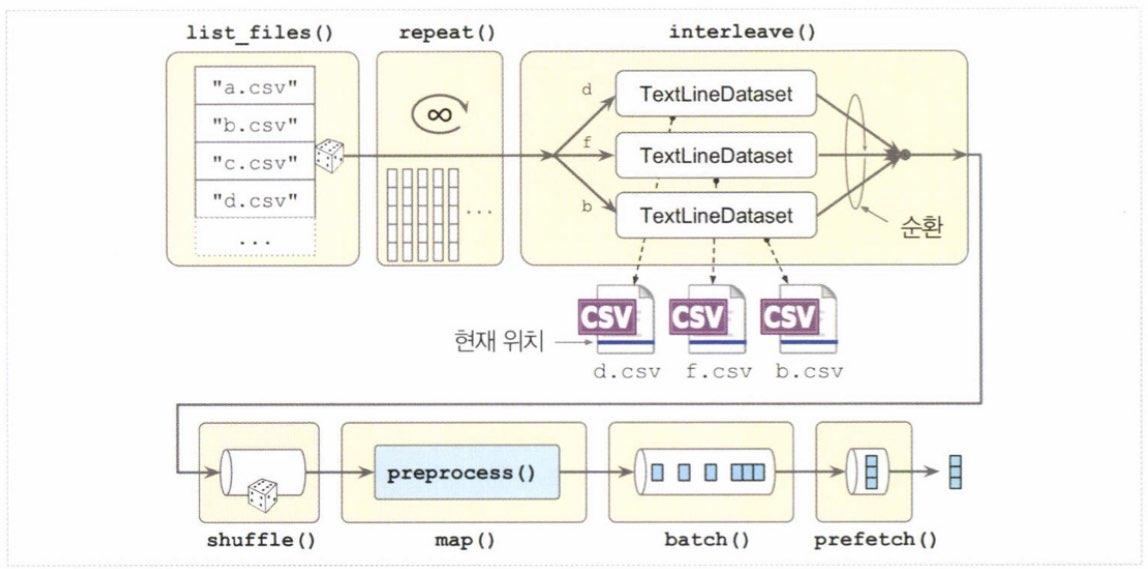

In [17]:
def csv_reader_dataset(filepaths, repeat = 1, n_reader = 5, n_read_thread = None, shuffle_buffer_size = 10000, n_parse_thread = 5, batch_size = 32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath : tf.data.TextLineDataset(filepath).skip(1),
        cycle_length = n_readers, num_parallel_calls = n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls = n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

### 13.1.5.prefatch
- 마지막 줄에 이 프리패치를 호출하면(위에서는 prefetch(1)), 데이터셋은 항상 한 배치가 미리 준비되도록 함
    - 다시 말해서 한 배치로 작업하는 동안 이 데이터셋이 동시에 다음 배치를 준비하며, GPU를 확실하게 사용할 수 있게 됨
    - 따라서 속도를 크게 향상시킬 수 있음
- 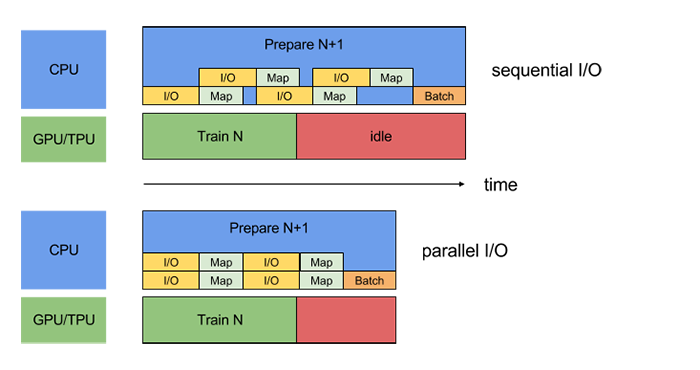
    - https://towardsdatascience.com/building-efficient-data-pipelines-using-tensorflow-8f647f03b4ce

### tf.keras와 데이터셋 사용하기
- 위에서 만든 csv_reader_dataset() 함수로 훈련 세트에 활용할 데이터셋을 만들 수 있음
    - tf.keras에서 알아서 반복을 처리하므로, 인자에 반복을 적어놓긴 했지만, 굳이 반복을 지정할 필요가 없음

In [18]:
# train_set = csv_reader_dataset(train_filepaths)
# val_set = csv_reader_dataset(valid_filepaths)
# t_set = csv_reader_dataset(test_filepaths)

-  위에서 만든 세트를 훈련할 때 인자로 대입해주기만 하면 됨

In [19]:
# model = keras.models.Sequential([...])
# model.copile([...])
# model.fit(tr_set, epochs = 100, validation_data = val_set)

In [20]:
# model.evaluate(t_set)
# new_set = test_set.take(3).map(lambda X, y:X) # 새로운 샘플 세개 가정
# model.predict(new_set)

- 참고로 predict에서는 넘파이 배열을 전달해도 됨